# Import required libraries and methods

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import LinearSVC
from nltk.stem import WordNetLemmatizer
import nltk
import pickle 

# Preprocessing function

In [2]:
lemmatizer = WordNetLemmatizer()
def clean_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])  # Lemmatize
    return text

# Define LSTWSVM_MultiClass

In [3]:
class LSTWSVM_MultiClass:
    def __init__(self, c1=1, c2=1, max_iter=1000):
        self.c1 = c1
        self.c2 = c2
        self.max_iter = max_iter
        self.models = []

    def fit(self, X, y):
        n_classes = len(np.unique(y))
        self.models = []
        for i in range(n_classes):
            binary_y = np.where(y == i, 1, -1)
            model = LinearSVC(C=self.c1, max_iter=self.max_iter, dual=False)
            model.fit(X, binary_y)
            self.models.append(model)

    def predict(self, X):
        decision_scores = np.array([model.decision_function(X) for model in self.models]).T
        return np.argmax(decision_scores, axis=1)

# Custom LSTWSVM training function

In [4]:
def lstwsvm_train(X_train, y_train, c1=1, c2=1):
    lstwsvm = LSTWSVM_MultiClass(c1=c1, c2=c2)
    lstwsvm.fit(X_train, y_train)
    return lstwsvm

# Load and preprocess dataset

In [5]:
df = pd.read_csv('Reuters_News_Articles.csv', delimiter=';')
df['title'] = df['title'].apply(clean_text)

# Encode labels

In [6]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['topic'])

# Split dataset

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df['title'], y, test_size=0.2, random_state=42)

# TF-IDF Vectorization

In [9]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=20000, ngram_range=(1, 2), min_df=5, max_df=0.8)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train LSTWSVM model

In [10]:
lstwsvm_model = lstwsvm_train(X_train_tfidf, y_train, c1=1, c2=1)

# Predict using LSTWSVM

In [11]:
def predict_category_lstwsvm(new_title):
    new_title_tfidf = vectorizer.transform([new_title])
    predicted_category = lstwsvm_model.predict(new_title_tfidf)
    return label_encoder.inverse_transform(predicted_category)[0]

# Example usage

In [12]:
input_title = "China flag in Isro ad: PM Modi blasts DMK, party hits back"
predicted_category = predict_category_lstwsvm(input_title)
print(f"The predicted category for the input title using LSTWSVM is: {predicted_category}")

The predicted category for the input title using LSTWSVM is: NATION


# Evaluate the LSTWSVM model

In [13]:
y_pred = lstwsvm_model.predict(X_test_tfidf)
print("LSTWSVM Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

LSTWSVM Accuracy: 0.8660767639623075
               precision    recall  f1-score   support

     BUSINESS       0.86      0.84      0.85      5940
ENTERTAINMENT       0.92      0.93      0.92      6102
       HEALTH       0.82      0.89      0.86      5959
       NATION       0.76      0.77      0.77      5931
      SCIENCE       0.93      0.89      0.91      1563
       SPORTS       0.96      0.96      0.96      5982
   TECHNOLOGY       0.93      0.92      0.92      6043
        WORLD       0.79      0.75      0.77      5990

     accuracy                           0.87     43510
    macro avg       0.87      0.87      0.87     43510
 weighted avg       0.87      0.87      0.87     43510



# Confusion Matrix

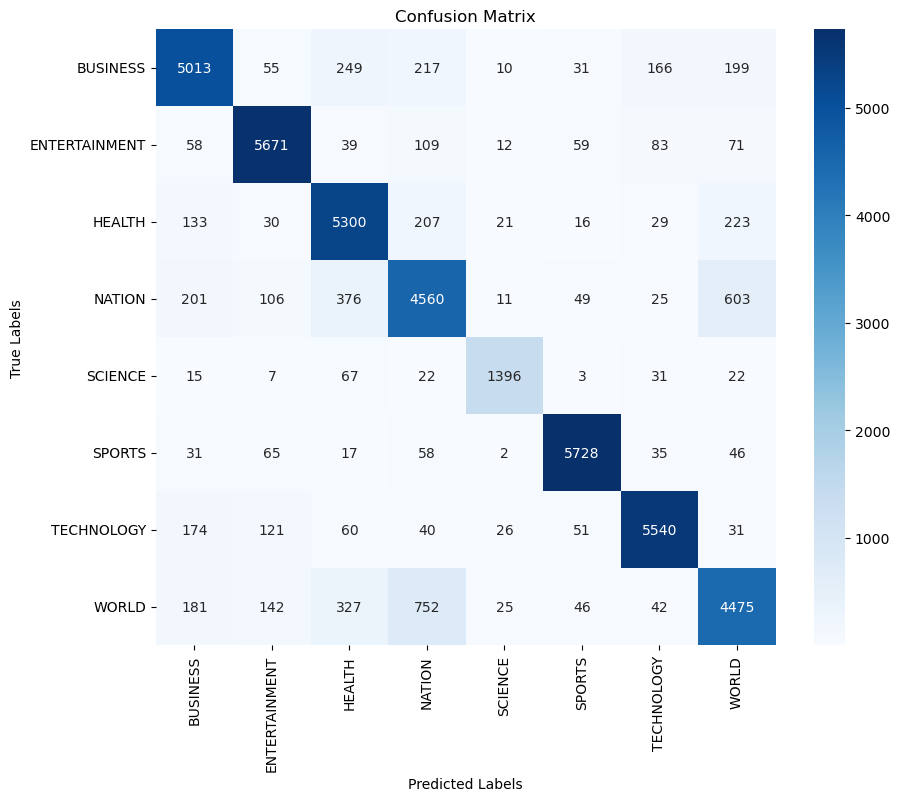

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Converting Model into Binary file

In [14]:
with open('trained_model.pkl', 'wb') as model_file: 
    pickle.dump(lstwsvm_model, model_file) 
with open('vectorizer.pkl', 'wb') as vectorizer_file: 
    pickle.dump(vectorizer, vectorizer_file) 